In [1]:
import pytesseract
import cv2
import difflib
import os
import re
from tabulate import tabulate
from matplotlib import pyplot as plt

In [2]:
# Label Object Definition with Class Variables and Functions
class Label:
    def __init__(self):
        self.name = ''
        self.calories = 'N/A'
        self.total_fat = 'N/A'
        self.sat_fat = 'N/A'
        self.trans_fat = 'N/A'
        self.cholesterol = 'N/A'
        self.sodium = 'N/A'
        self.total_carbs = 'N/A'
        self.fiber = 'N/A'
        self.sugar = 'N/A'
        self.protein = 'N/A'
        self.vit_A = 'N/A'
        self.calc = 'N/A'
        self.vit_C = 'N/A'
        self.iron = 'N/A'
    
    def print_info(self):
        tbl = [
               ['Name', self.name], 
               ['Calories', self.calories], 
               ['Total Fat (g)', self.total_fat],
               ['Saturated Fat (g)', self.sat_fat],
               ['Trans Fat (g)', self.trans_fat],
               ['Cholesterol (mg)', self.cholesterol],
               ['Sodium (mg)', self.sodium],
               ['Total Carbs (g)', self.total_carbs],
               ['Dietary Fiber (g)', self.fiber],
               ['Sugars (g)', self.sugar],
               ['Protein (g)', self.protein]
              ]
        print(tabulate(tbl))

In [3]:
# Imputing Missing Values with 0
# 0 can be considered a "safe" value to impute as replacing missing values with 0 can never decrease the accuracy of a reading,
# it can either increase the accuracy or not change it at all
def manage_nas(label):
    if label.calories == 'N/A' or label.calories == '':
        label.calories = '0'
    if label.total_fat == 'N/A' or label.total_fat == '':
        label.total_fat = '0'
    if label.sat_fat == 'N/A' or label.sat_fat == '':
        label.sat_fat = '0'
    if label.trans_fat == 'N/A' or label.trans_fat == '':
        label.trans_fat = '0'
    if label.cholesterol == 'N/A' or label.cholesterol == '':
        label.cholesterol = '0'
    if label.sodium == 'N/A' or label.sodium == '':
        label.sodium = '0'
    if label.total_carbs == 'N/A' or label.total_carbs == '':
        label.total_carbs = '0'
    if label.fiber == 'N/A' or label.fiber == '':
        label.fiber = '0'
    if label.sugar == 'N/A' or label.sugar == '':
        label.sugar = '0'
    if label.protein == 'N/A' or label.protein == '':
        label.protein = '0'
    return label

In [4]:
# Conducting Character Replacement to Correct Numbers Read as Letters
# Specific replacements were chosen based on experimentation with database
def fix_values(val):
    val = val.replace('O', '0')
    val = val.replace('o', '0')
    val = val.replace('i', '1')
    val = val.replace('I', '1')
    if len(val) > 1 and val[len(val) - 1] == '9':
        val = val[:-1] + 'g'
    val = re.sub(r'[^0-9.]', '', val)
    return val

In [5]:
# Parsing of the Label Text Read by Tesseract
# Specific nutrition values extracted and stored in a new Label object for each label
def parse_nutrition(label_text):
    lbl = Label()
    label_list = label_text.split()
    for i in range(1, len(label_list) - 1):
        if label_list[i].lower() == 'calories':
            lbl.calories = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'fat':
            if label_list[i - 1].lower() == 'total' and lbl.total_fat == 'N/A':
                lbl.total_fat = fix_values(label_list[i + 1])
            elif label_list[i - 1].lower() == 'saturated' and lbl.sat_fat == 'N/A':
                lbl.sat_fat = fix_values(label_list[i + 1])
            elif label_list[i - 1].lower() == 'trans' and lbl.trans_fat == 'N/A':
                lbl.trans_fat = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'cholesterol' and lbl.cholesterol == 'N/A':
            lbl.cholesterol = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'sodium' and lbl.sodium == 'N/A':
            lbl.sodium = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'carbohydrate' or label_list[i].lower() == 'carb.' and lbl.total_carbs == 'N/A':
            lbl.total_carbs = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'fiber' and lbl.fiber == 'N/A':
            lbl.fiber = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'sugars' and lbl.sugar == 'N/A':
            lbl.sugar = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'protein' and lbl.protein == 'N/A':
            lbl.protein = fix_values(label_list[i + 1])
        elif label_list[i].lower() == 'a' and lbl.vit_A == 'N/A':
            lbl.vit_A = label_list[i + 1]
        elif label_list[i].lower() == 'c' and lbl.vit_C == 'N/A':
            lbl.vit_C = label_list[i + 1]
        elif label_list[i].lower() == 'calcium' and lbl.calc == 'N/A':
            lbl.calc = label_list[i + 1]
        elif label_list[i].lower() == 'iron' and lbl.iron == 'N/A':
            lbl.iron = label_list[i + 1]
        
    return lbl

In [6]:
# Prompting User for Input to Conduct Error Correction and Accuracy Analysis
def eval_metric(label):
    label.print_info()
    err = input("Is there an error in the reading of {} (Y/N)? ".format(label.name))
    if err.lower() == 'y':
        print("Please enter correct values for each incorrect nutrient.\nDo not enter anything for values that were initially read correctly.")
        updated_vals = {}
        updated_vals['cals'] = input("Calories:          ")
        updated_vals['totf'] = input("Total Fat (g):     ")
        updated_vals['satf'] = input("Saturated Fat (g): ")
        updated_vals['traf'] = input("Trans Fat (g):     ")
        updated_vals['chol'] = input("Cholesterol (mg):  ")
        updated_vals['sodi'] = input("Sodium (mg):       ")
        updated_vals['carb'] = input("Total Carbs (g):   ")
        updated_vals['fibr'] = input("Dietary Fiber (g): ")
        updated_vals['sugr'] = input("Sugars (g):        ")
        updated_vals['prot'] = input("Protein (g):       ")
        inconsistencies = 0
        for update in updated_vals:
            if updated_vals[update] != '':
                inconsistencies = inconsistencies + 1
        print('{} inconsistencies noted.'.format(inconsistencies))
        print('System accuracy: {}%'.format(100 - inconsistencies / 10 * 100))
        if updated_vals['cals'] != '':
            label.calories = updated_vals['cals']
        if updated_vals['totf'] != '':
            label.total_fat = updated_vals['totf']
        if updated_vals['satf'] != '':
            label.sat_fat = updated_vals['satf']
        if updated_vals['traf'] != '':
            label.trans_fat = updated_vals['traf']
        if updated_vals['chol'] != '':
            label.cholesterol = updated_vals['chol']
        if updated_vals['sodi'] != '':
            label.sodium = updated_vals['sodi']
        if updated_vals['carb'] != '':
            label.total_carbs = updated_vals['carb']
        if updated_vals['fibr'] != '':
            label.fiber = updated_vals['fibr']
        if updated_vals['sugr'] != '':
            label.sugar = updated_vals['sugr']
        if updated_vals['prot'] != '':
            label.protein = updated_vals['prot']
        # label.print_info()
        return 100 - inconsistencies / 10 * 100
    else:
        inconsistencies = 0
        print('{} inconsistencies noted.'.format(inconsistencies))
        print('System accuracy: {}%'.format(100 - inconsistencies / 10 * 100))
        return 100 - inconsistencies / 10 * 100

In [7]:
# Calculating Total Macros Consumed Based on User-Provided Labels and Amounts Consumed
def calc_total_macros(labels, consumed):
    totals = {'Calories: ': 0,
              'Total Fat (g): ': 0,
              'Saturated Fat (g): ': 0,
              'Trans Fat (g): ': 0,
              'Cholesterol (mg): ': 0,
              'Sodium (mg): ': 0,
              'Total Carbs (g): ': 0,
              'Dietary Fiber (g): ': 0,
              'Sugars (g): ': 0,
              'Protein (g): ': 0}
    
    for i in range(len(labels)):
        totals['Calories: '] = totals['Calories: '] + float(labels[i].calories) * consumed[i]
        totals['Total Fat (g): '] = totals['Total Fat (g): '] + float(labels[i].total_fat) * consumed[i]
        totals['Saturated Fat (g): '] = totals['Saturated Fat (g): '] + float(labels[i].sat_fat) * consumed[i]
        totals['Trans Fat (g): '] = totals['Trans Fat (g): '] + float(labels[i].trans_fat) * consumed[i]
        totals['Cholesterol (mg): '] = totals['Cholesterol (mg): '] + float(labels[i].cholesterol) * consumed[i]
        totals['Sodium (mg): '] = totals['Sodium (mg): '] + float(labels[i].sodium) * consumed[i]
        totals['Total Carbs (g): '] = totals['Total Carbs (g): '] + float(labels[i].total_carbs) * consumed[i]
        totals['Dietary Fiber (g): '] = totals['Dietary Fiber (g): '] + float(labels[i].fiber) * consumed[i]
        totals['Sugars (g): '] = totals['Sugars (g): '] + float(labels[i].sugar) * consumed[i]
        totals['Protein (g): '] = totals['Protein (g): '] + float(labels[i].protein) * consumed[i]
    
    return totals

In [8]:
# Visualizing Data and Displaying Overall Nutrition Summary for User Compared to Recommended Standards Set by the FDA
# Summary displayed in textual and visual forms as a series of pie charts
def disp_summary(totals):
    recc_vals = {'Total Fat (g): ': 78,
                 'Saturated Fat (g): ': 20,
                 'Trans Fat (g): ': 2,
                 'Cholesterol (mg): ': 300,
                 'Sodium (mg): ': 2300,
                 'Total Carbs (g): ': 275,
                 'Dietary Fiber (g): ': 28,
                 'Protein (g): ': 50}
    summary = []
    for nutrient in totals:
        if nutrient == 'Calories: ' or nutrient == 'Sugars (g): ':
            summary.append([nutrient, totals[nutrient]])
        else:
            summary.append([nutrient, totals[nutrient], round(totals[nutrient] / recc_vals[nutrient] * 100, 0)])
    print('Nutrition Summary: ')
    print(tabulate(summary, headers=['Nutrient', 'Amount', '% Daily Value']))
    
    fig,axs = plt.subplots(2, 4, figsize=(20, 10))
    axs[0][0].pie([summary[1][2], max(100 - summary[1][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[0][0].set_title('Total Fat: ')
    axs[0][1].pie([summary[2][2], max(100 - summary[2][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[0][1].set_title('Saturated Fat: ')
    axs[0][2].pie([summary[3][2], max(100 - summary[3][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[0][2].set_title('Trans Fat: ')
    axs[0][3].pie([summary[4][2], max(100 - summary[4][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[0][3].set_title('Cholesterol: ')
    axs[1][0].pie([summary[5][2], max(100 - summary[5][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[1][0].set_title('Sodium: ')
    axs[1][1].pie([summary[6][2], max(100 - summary[6][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[1][1].set_title('Total Carbs: ')
    axs[1][2].pie([summary[7][2], max(100 - summary[7][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[1][2].set_title('Dietary Fiber: ')
    axs[1][3].pie([summary[9][2], max(100 - summary[9][2], 0)], labels=['Consumed', 'Not Consumed'], autopct='%1.1f%%', colors=['lightskyblue', 'gray'], startangle=45)
    axs[1][3].set_title('Protein: ')
    return summary

In [9]:
# Providing Suggestions for Improvements to a User's Diet Based on their Consumption Habits and the Recommended Standards
def output_suggestions(summary):
    recc_vals = {'Total Fat (g): ': 78,
                 'Saturated Fat (g): ': 20,
                 'Trans Fat (g): ': 2,
                 'Cholesterol (mg): ': 300,
                 'Sodium (mg): ': 2300,
                 'Total Carbs (g): ': 275,
                 'Dietary Fiber (g): ': 28,
                 'Protein (g): ': 50}
    deficiency = 'Your consumption of {} is low, consider eating more daily.'
    optimal = 'Your consumption of {} is great, you are close to meeting the recommended goal!.'
    surplus = 'Your consumption of {} is high, consider eating less daily.'
    limit = 'Your consumption of {} is perfect, you are not exceeding the recommended limit!'
    for i in range(len(summary)):
        if summary[i][0] != 'Calories: ' and summary[i][0] != 'Sugars (g): ':
            print('')
            nutrient = summary[i][0]
            nutrient = nutrient.replace(' (g): ', '')
            nutrient = nutrient.replace(' (mg): ', '')
            dv = summary[i][2]
            if nutrient == 'Total Fat' or nutrient == 'Cholesterol' or nutrient == 'Total Carbs' or nutrient == 'Protein' or nutrient == 'Dietary Fiber':
                if dv < 80:
                    print(deficiency.format(nutrient))
                    if nutrient == 'Total Fat':
                        print('Healthier foods to help you meet your total fat goal include avocados and eggs.')
                    elif nutrient == 'Cholesterol':
                        print('Healthier foods to help you meet your cholesterol goal include eggs and cheese.')
                    elif nutrient == 'Total Carbs':
                        print('Healthier foods to help you meet your cholesterol goal include oats and fruits.')
                    elif nutrient == 'Protein':
                        print('Healthier foods to help you meet your protein goal include eggs and white meat.')
                    elif nutrient == 'Dietary Fiber':
                        print('Healthier foods to help you meet your protein goal include fruits and lentils.')
                elif dv < 110:
                    print(optimal.format(nutrient))
                else:
                    print(surplus.format(nutrient))
                print('Ideal range for {} is between 80% and 110% of the standard daily value.'.format(nutrient))
            elif nutrient == 'Saturated Fat' or nutrient == 'Trans Fat':
                if dv < 100:
                    print(limit.format(nutrient))
                else:
                    print(surplus.format(nutrient))
                    if nutrient == 'Saturated Fat':
                        print('Consider reducing your intake of foods such as red meat and ice cream to lower saturated fat consumption.')
                    else:
                        print('Consider reducing your intake of fried foods to lower trans fat consumption.')
                print('Ideal range for {} is less than 100% of the standard daily value.'.format(nutrient))
            elif nutrient == 'Sodium':
                if dv < 50:
                    print(deficiency.format(nutrient))
                    print('Healthier foods to help you meet your sodium goal include vegetables such as celery and carrots.')
                elif dv < 100:
                    print(limit.format(nutrient))
                else:
                    print(surplus.format(nutrient))
                    print('Consider reducing your intake of fried foods and processed meats to lower sodium consumption.')
                print('Ideal range for {} is between 50% and 100% of the standard daily value.'.format(nutrient))

        

In [33]:
# Pulling Images from Testing Directory
fp = 'Testing/Day/'
images = os.listdir(fp)
# print(images)

In [34]:
# Performing CV Image Manipulations and Passing each Image through Tesseract to Parse Data
labels = []
texts = []
for img in images:
    img = fp + img
    img_cv = cv2.imread(img)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    ret,img_thresh = cv2.threshold(img_gray,170,255,0)
    img_thresh_disp = cv2.cvtColor(img_thresh, cv2.COLOR_BGR2RGB)
    label_text = pytesseract.image_to_string(img_thresh, config='--psm 4')
    lbl = parse_nutrition(label_text)
    texts.append(label_text)
    lbl.name = img.split('.')[0][12:]
    lbl = manage_nas(lbl)
    labels.append(lbl)

In [35]:
# Calculating Average Accuracy of System and Prompting User for Error Correction
avg_acc = 0
for label in labels:
    avg_acc = avg_acc + eval_metric(label)
avg_acc = avg_acc / len(labels)
print("Average system accuracy across all inputs: {}%".format(avg_acc))

-----------------  ----
Name               test
Calories           150
Total Fat (g)      8
Saturated Fat (g)  1.5
Trans Fat (g)      0
Cholesterol (mg)   0
Sodium (mg)        230
Total Carbs (g)    17
Dietary Fiber (g)  0
Sugars (g)         0
Protein (g)        0
-----------------  ----
Is there an error in the reading of test (Y/N)? n
0 inconsistencies noted.
System accuracy: 100.0%
-----------------  -----
Name               test2
Calories           0
Total Fat (g)      0
Saturated Fat (g)  0
Trans Fat (g)      0
Cholesterol (mg)   0
Sodium (mg)        20
Total Carbs (g)    2
Dietary Fiber (g)  0
Sugars (g)         0
Protein (g)        0
-----------------  -----
Is there an error in the reading of test2 (Y/N)? n
0 inconsistencies noted.
System accuracy: 100.0%
-----------------  -----
Name               test3
Calories           0
Total Fat (g)      8
Saturated Fat (g)  1.5
Trans Fat (g)      0
Cholesterol (mg)   0
Sodium (mg)        230
Total Carbs (g)    17
Dietary Fiber (g)  1
Sug

In [36]:
# Prompting User to Enter Amount Consumed
consumed = []
for label in labels:
    val = input("How much of {} was consumed today? ".format(label.name))
    if val == '':
        val = 0
    consumed.append(int(val))
# print(consumed)
totals = calc_total_macros(labels, consumed)

How much of test was consumed today? 1
How much of test2 was consumed today? 1
How much of test3 was consumed today? 1


Items Eaten Today: 
test - consumed 1 serving size(s)
test2 - consumed 1 serving size(s)
test3 - consumed 1 serving size(s)
Nutrition Summary: 
Nutrient              Amount    % Daily Value
------------------  --------  ---------------
Calories:                300
Total Fat (g):            16               21
Saturated Fat (g):         3               15
Trans Fat (g):             0                0
Cholesterol (mg):          0                0
Sodium (mg):             480               21
Total Carbs (g):          36               13
Dietary Fiber (g):         1                4
Sugars (g):                0
Protein (g):               3                6


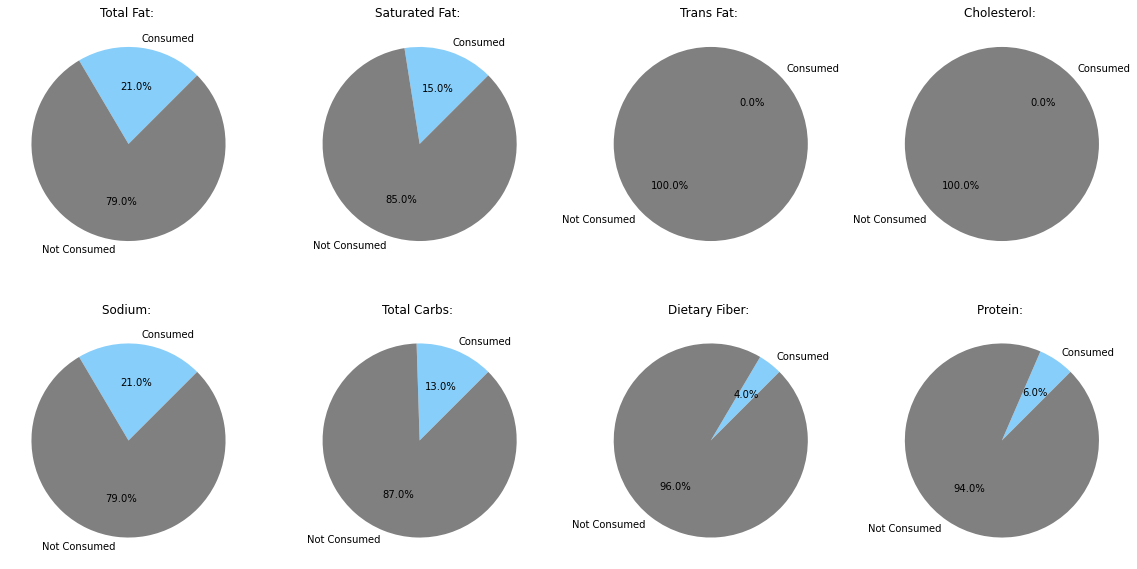

In [38]:
# Printing out User Nutrition Summary
print('Items Eaten Today: ')
for i in range(len(labels)): 
    print('{} - consumed {} serving size(s)'.format(labels[i].name, consumed[i]))
summary = disp_summary(totals)


In [39]:
output_suggestions(summary)


Your consumption of Total Fat is low, consider eating more daily.
Healthier foods to help you meet your total fat goal include avocados and eggs.
Ideal range for Total Fat is between 80% and 110% of the standard daily value.

Your consumption of Saturated Fat is perfect, you are not exceeding the recommended limit!
Ideal range for Saturated Fat is less than 100% of the standard daily value.

Your consumption of Trans Fat is perfect, you are not exceeding the recommended limit!
Ideal range for Trans Fat is less than 100% of the standard daily value.

Your consumption of Cholesterol is low, consider eating more daily.
Healthier foods to help you meet your cholesterol goal include eggs and cheese.
Ideal range for Cholesterol is between 80% and 110% of the standard daily value.

Your consumption of Sodium is low, consider eating more daily.
Healthier foods to help you meet your sodium goal include vegetables such as celery and carrots.
Ideal range for Sodium is between 50% and 100% of the